# Milestone 4
Grant Perkins

## Abstract
The Massachusetts Bay Transportation Authority (MBTA) has a commitment to providing their customers transparent performance measures. To aid in this commitment, this project predicts whether the Red Line will be late, given just 2 weeks of historical data on the other rapid transit lines. The MBTA Reliability dataset was split into disjoint training and testing sets. An exhaustive search of methods of scaling, feature decomposition, and models was performed, as well as five-fold cross validation. This produced a normalization into PCA into multi-layer perceptron pipeline capable of 67% accuracy on predicting if the Red Line will be late.

## Overview and Motivation
The MBTA has a commitment to providing “accurate and timely information” about delays in their services (https://www.mbta.com/policies/our-commitment-you). Predicting if the MBTA’s Red Line Rapid Transit will be late, based on the reliability of the other lines in the past two weeks, would improve accuracy of reported information, in line with business goals.

The dataset used in this project can be found [here](https://mbta-massdot.opendata.arcgis.com/datasets/MassDOT::mbta-bus-commuter-rail-rapid-transit-reliability/about). This dataset contains daily information about train reliabilities from 2015 to the start of December 2022. There is information about the three Green lines, the Blue line, the Orange line, and the Red line. For each of these trains on each day, it is provided both how many people tried to get on the train and how many people wanted to get on the train. Dividing these numbers provides a reliability percentage. The median percentage for the Red line is 91%. For this project, the red line is considered late if it is less than 91% reliable on the given day. This problem will be approached as a regression task, with the predicted reliability then used for binary classification. Both regression and classification metrics will be reported.

## Related Work
My MQP was related to time series prediction on stock market data, which made me interested in exploring more time series prediction problems. The paper for this MQP can be found [here](https://arxiv.org/abs/2212.08734). I also happened to have visited Boston via the commuter rail in the weekend prior to choosing a project topic.

## Initial Questions
The central question for this project has hardly changed throughout the lifespan of this project. That is: can the reliability of the MBTA Red Line be predicted using data from other rapid transit lines? Or more specifically, can features be derived from the MBTA's reliability dataset to classify whether the Red Line Rapid Transit will be late during peak hours to at least 60% accuracy? The target accuracy has been reduced from 75% to 60%, as this problem ended up being more challenging than I was expecting.

## Data
The dataset used in this project can be found [here](https://mbta-massdot.opendata.arcgis.com/datasets/MassDOT::mbta-bus-commuter-rail-rapid-transit-reliability/about). The source dataset contained information about all MBTA services including busses and non-city trains, and also had one row for each service on each day. This means on a given monday, there is a row for the red line, a row for the blue line, etc. For this project, I transform the dataset by having one row for each day, and columns for each of the rapid transit lines. The last bit of initial data manipulation was to create a predictor variable, which was taken by dividing the number of people wanting to get on the Red line by how many people actually got on, for each day.

## Exploratory Data Analysis
My EDA focused on evaluating the ability of the original features for use in prediction. First, a table of missing data percentages was produced. It was found that minimal data was missing, so the median value of each column was used to interpolate. Then, outliers were investigated. Histograms of each column were produced to evaluate the presence of outliers, as well as box plots. Very few outliers were found, so no action was taken. It was also found that most columns were left-skewed, which has no impact on the quality of the data. Next, a summary statistics table was produced. It was found that the Red line is the most used line, and the three Green lines were the least used. Correlation analysis was finally performed. First, a correlation matrix was made, which showed strong correlation between numerators and denominators, and semi-strong correlation between the three Green lines, as well as the Orange line to the Red line and the Blue line to the Red line. Little correlation was found between the Green lines and the Red line. Finally, scatterplots were made in an attempt to find correlation between individual samples of different lines. These scatter plots showed very weak correlation, suggesting deeper models are needed for prediction than simple linear regression. I also tried using a "fraction dataset", where I divided the numerator columns by the denominator columns, and ran all of the statistical tests used above. I found no convincing evidence that this dataset performed any better than the original (pre-division), so I chose not to use the fraction dataset for my project.

## Final Analysis
I'm now going to go step-by-step through my final analysis, in an attempt to predict the reliability of the MBTA Red line. The first step is to load the cleaned dataset. I break the dataset up into two week periods of observation, and attempt to predict the 15th day. This is done below.


In [1]:
# import necessary packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# scalers
import sklearn.preprocessing
# decomposition
import sklearn.decomposition
# models
import sklearn.svm
import sklearn.neural_network
import sklearn.ensemble
import sklearn.neural_network
from sklearn.pipeline import Pipeline
import sklearn.metrics
import sklearn.model_selection

from dataset import MBTADataset

In [2]:
# load dataset
window_size = 14  # how many days are in one sample
dataset = MBTADataset(window_size)  # load the dataset, make 14 day windows
train_X, train_y, test_X, test_y = dataset.make_sklearn_dataset()  # train test split, 80:20

1429 samples in train set
358 samples in test set


With the dataset now loaded, I want to explore what data scaling, feature decomposition, and ML model best predictions reliability. I also want to know the optimal hyparameters for these modules. Below, I define three dictionaries used for exhaustively searching permutations. The following modules will be explored:

Scalers:
 - Standard scaler
 - MinMax scaler
 - Normal scaler
 - no scaler used

Feature decompositions:
 - Principle Component Analysis
 - Factor Analysis
 - no decomposition used

Model:
 - Support Vector Machine
 - Random Forest
 - AdaBoost
 - Multi-layer Perceptron

Appropriate hyperparameters for each of these modules will be exhaustively explored. You might wonder why I am using regression models, and not classification. I am doing this because through experimentation, I found it difficult to analyze whether my classification models were learning in intermediate steps. Regression models were easier to interpret for me, and I can easily change the regression results (predicted reliability as a percentage) into classification results (is the train less than 90% reliable today?).

In [3]:
random_state = 1130
# make list of scalers, decompositions, and models for gridsearch
scalers = {"standard_scaler": sklearn.preprocessing.StandardScaler(),
           "minmax_scaler": sklearn.preprocessing.MinMaxScaler(),
           "normal_scaler": sklearn.preprocessing.Normalizer(),
           "none": None}

# PCA with list of hyperparamter options for hyperparameter tuning
decompositions = {"pca": [sklearn.decomposition.PCA(), {"n_components": [*range(14, 14 ** 2 + 1, 14)]}],
                  "fa": [sklearn.decomposition.FactorAnalysis(), {"n_components": [*range(14, 14 ** 2 + 1, 14)]}],
                  "none": None}

# list of models and parameters to exhaustively try. max iterations set just so program doesn't hang.
models = {"svm": [sklearn.svm.SVR(max_iter=1000),
                  {"kernel": ["linear", "poly", "rbf", "sigmoid"]}],
          "rf": [sklearn.ensemble.RandomForestRegressor(max_depth=10, random_state=random_state),
                 {"n_estimators": [*range(25, 100 + 1, 25)], "criterion": ["squared_error", "poisson"]}],
          "adaboost": [sklearn.ensemble.AdaBoostRegressor(random_state=random_state),
                       {"n_estimators": [*range(25, 100 + 1, 25)]}],
          "mlp": [sklearn.neural_network.MLPRegressor(random_state=random_state),
                  {"hidden_layer_sizes": [(25, 10), (15, 5)], "solver": ["adam", "sgd"]}]}

With this list of modules and their respective hyperparameters, I will now exhaustively explore all combinations of modules, and determine the best hyperparameters for that combination. Finally, I will compare the MSE of this combination against the best previous combination, and save the new best. The best combination of modules, as well as its hyperparameters, is outputted for later use.

In [4]:
# make all combinations of scalers, decompositions, and models.
# do grid search on these iterations.
# find best combo with best params.

print("Beginning exhaustive search...")
# save best model and parameters for later
best = {"score": 100, "steps": None, "parameters": None}
# loop through all permuations
for scaler_name, scaler in scalers.items():
    for decomposition_name, decomposition_data in decompositions.items():
        for model_name, model_data in models.items():
            print(f"Starting scaler={scaler_name}, decomposition={decomposition_name}, model={model_name}")
            param_grid = {}
            steps = []
            # use a scaler?
            if scaler_name != "none":
                # add scaler to steps
                steps.append((scaler_name, scaler))
            # use a decomposition?
            if decomposition_name != "none":
                decomposition, params = decomposition_data
                # add all parameters to param grid
                for param_name, args in params.items():
                    param_grid.update({f"{decomposition_name}__{param_name}": args})
                # add pca to steps
                steps.append((decomposition_name, decomposition))
            model, params = model_data
            for param_name, args in params.items():
                # add all parameters to param grid
                param_grid.update({f"{model_name}__{param_name}": args})
                # add model to steps
            steps.append((model_name, model))

            pipe = Pipeline(steps=steps)

            # create 5-fold cross validation grid search object for this permuation
            # will find best parameters for this specific scaler, decomposition, and model combination
            search = sklearn.model_selection.GridSearchCV(pipe, param_grid, n_jobs=5, scoring="neg_mean_squared_error",
                                                          error_score="raise")
            try:
                search.fit(train_X, train_y)
                print(f"Average MSE across 5 folds:{-search.best_score_:0.9f}")
                print("Parameters used:", search.best_params_)
                # using negative MSE, we try to maximize score
                if -search.best_score_ < best["score"]:
                    best["score"] = -search.best_score_
                    best["steps"] = steps
                    best["parameters"] = search.best_params_
                    print("NEW BEST FOUND")
                print()
            except:
                print("Failed to converge. Moving to next.")
                print()
print("Best found after search.")
print(best)

Beginning exhaustive search...
Starting scaler=standard_scaler, decomposition=pca, model=svm
Average MSE across 5 folds:0.004603069
Parameters used: {'pca__n_components': 28, 'svm__kernel': 'rbf'}
NEW BEST FOUND

Starting scaler=standard_scaler, decomposition=pca, model=rf
Average MSE across 5 folds:0.003513236
Parameters used: {'pca__n_components': 154, 'rf__criterion': 'poisson', 'rf__n_estimators': 25}
NEW BEST FOUND

Starting scaler=standard_scaler, decomposition=pca, model=adaboost
Average MSE across 5 folds:0.002619690
Parameters used: {'adaboost__n_estimators': 25, 'pca__n_components': 154}
NEW BEST FOUND

Starting scaler=standard_scaler, decomposition=pca, model=mlp
Average MSE across 5 folds:0.022010542
Parameters used: {'mlp__hidden_layer_sizes': (15, 5), 'mlp__solver': 'sgd', 'pca__n_components': 112}

Starting scaler=standard_scaler, decomposition=fa, model=svm
Average MSE across 5 folds:0.004322060
Parameters used: {'fa__n_components': 56, 'svm__kernel': 'rbf'}

Starting s

Average MSE across 5 folds:0.003111481
Parameters used: {'adaboost__n_estimators': 25}

Starting scaler=none, decomposition=none, model=mlp
Failed to converge. Moving to next.

Best found after search.
{'score': 0.0022750882947646803, 'steps': [('normal_scaler', Normalizer()), ('pca', PCA()), ('mlp', MLPRegressor(random_state=1130))], 'parameters': {'mlp__hidden_layer_sizes': (25, 10), 'mlp__solver': 'adam', 'pca__n_components': 126}}


After a very exhaustive search, it was found that normalizing the data, then using PCA with 126 components, then using a multi-layer perceptron with hidden layers of size 25 and then 10 is the optimal solution for predicting red line reliability. Now, it is time to get more in-depth metrics.

In [7]:
# based on the output, the following pipeline is the best!
steps = [('normal_scaler', sklearn.preprocessing.Normalizer()), ('pca', sklearn.decomposition.PCA(n_components=126)),
         ('mlp', sklearn.neural_network.MLPRegressor(random_state=1130, hidden_layer_sizes=(25, 10), solver="adam"))]
pipeline = Pipeline(steps=steps)
pipeline.fit(train_X, train_y)

Pipeline(steps=[('normal_scaler', Normalizer()), ('pca', PCA(n_components=126)),
                ('mlp',
                 MLPRegressor(hidden_layer_sizes=(25, 10), random_state=1130))])

In [8]:
# calculate regression metrics
preds = pipeline.predict(test_X)
r2 = sklearn.metrics.r2_score(test_y, preds)
mae = sklearn.metrics.mean_absolute_error(test_y, preds)
mse = sklearn.metrics.mean_squared_error(test_y, preds)
rmse = mse ** 0.5
print("Regression metrics for best model:")
print("r^2:", r2)
print("MAE:", mae)
print("RMSE:", rmse)

Regression metrics for best model:
r^2: 0.03884912275644559
MAE: 0.02929222232883267
RMSE: 0.04005672537412106


We get very low MAE and RMSE, but also a very low R squared? Time to look into that.

Text(0.5, 1.0, 'Distribution of Predictions and True Values')

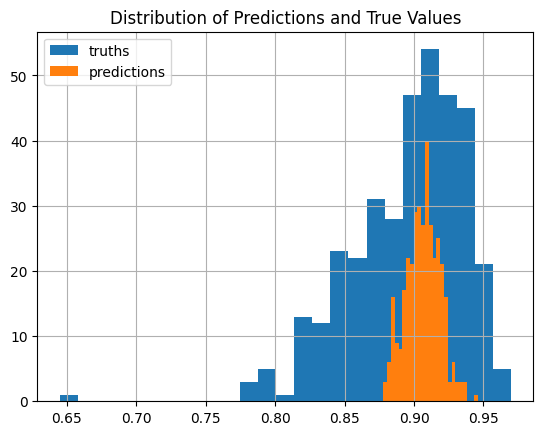

In [9]:
# investigate why my R2 is so terrible
df = {"predictions": preds, "truths": test_y}
df = pd.DataFrame(df)
df["truths"].hist(bins=25, legend=True)
df["predictions"].hist(bins=25, legend=True)
plt.title("Distribution of Predictions and True Values")

It seems that the distributions are the same, but the predictions are centered more around the median. Interesting! Maybe clasification will work.

In [10]:
# calculate initial classification metrics
class_preds = preds < .91
class_test_y = test_y < .91
print(sklearn.metrics.classification_report(class_test_y, class_preds))

              precision    recall  f1-score   support

       False       0.63      0.58      0.61       154
        True       0.70      0.74      0.72       204

    accuracy                           0.67       358
   macro avg       0.67      0.66      0.66       358
weighted avg       0.67      0.67      0.67       358



67% accuracy! Awesome. And above 50% precision and recall for all classes. Huge success. Now, I will look at producing ROC curves.

In [11]:
# produce "confidences" for prediction. Kind of tricky given the regression --> classification nature of my approach.
# here, I decide that confidence is the number of standard deviations from the mean of the predicted reliability. If it is far from the median, it is mroe confident it is either late or on time. This value is minmax scaled between 0 and 1, for use in ROC calculations.
normalized = (preds - np.mean(preds)) / np.std(preds)
confidences = (normalized.max() - normalized) / (normalized.max() - normalized.min())
fpr, tpr, thresh = sklearn.metrics.roc_curve(class_test_y, confidences)
auc = sklearn.metrics.auc(fpr, tpr)

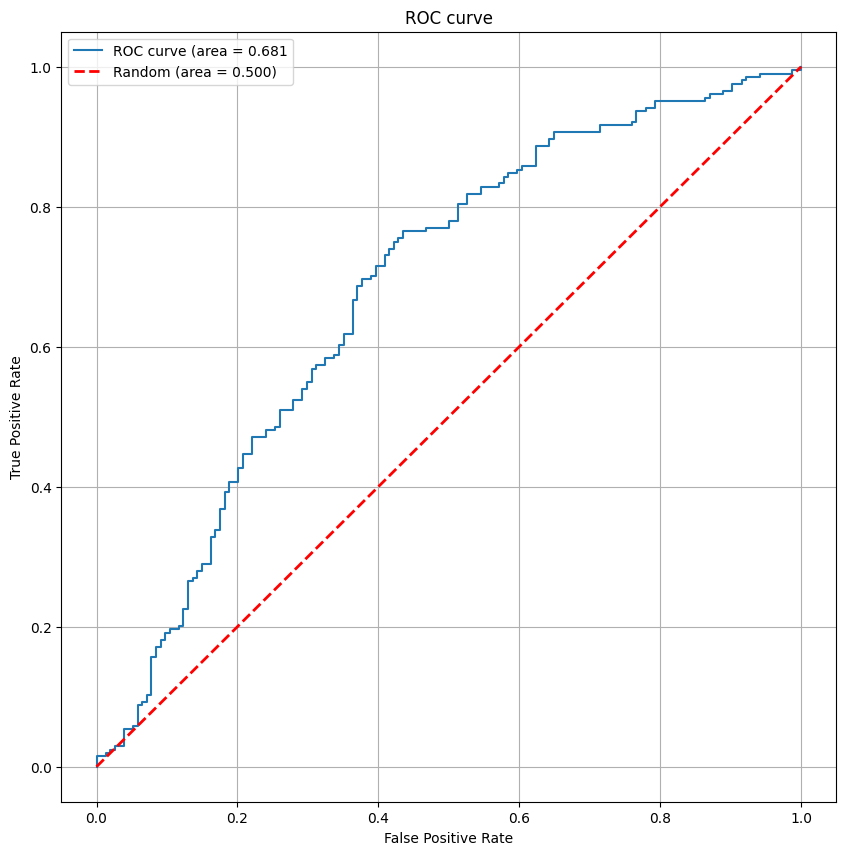

In [12]:
# plot my ROC curve!
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, label=f'ROC curve (area = {round(auc, 3)}')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random (area = 0.500)')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

And a not-too-shabby ROC curve. Very very slick.

## Conclusion

I produced a model that was highly successful at predicting whether the MBTA's Red line would be late. It also serves a double purpose of producing a continuous confidence of that prediction. This model exceeded the 60% accuracy goal. 